# Introduction

### Basic info
This notebook uses TabTransformer, a deep tabular data modeling architecture for supervised and semi-supervised learning. The TabTransformer is built upon self-attention based Transformers. The Transformer layers transform the embeddings of categorical features into robust contextual embeddings to achieve higher predictive accuracy.

Architecture of TabTransformer:

<img src=attachment:57ae157a-7ef2-44b3-848b-50e17517a580.png width="400">

### Inspired by: 
[Keras3-TabTransformer](https://www.kaggle.com/code/usharengaraju/keras3-tabtransformer)

### References:

https://keras.io/examples/structured_data/tabtransformer/

[Paper. TabTransformer: Tabular Data Modeling Using Contextual Embeddings](https://arxiv.org/abs/2012.06678)
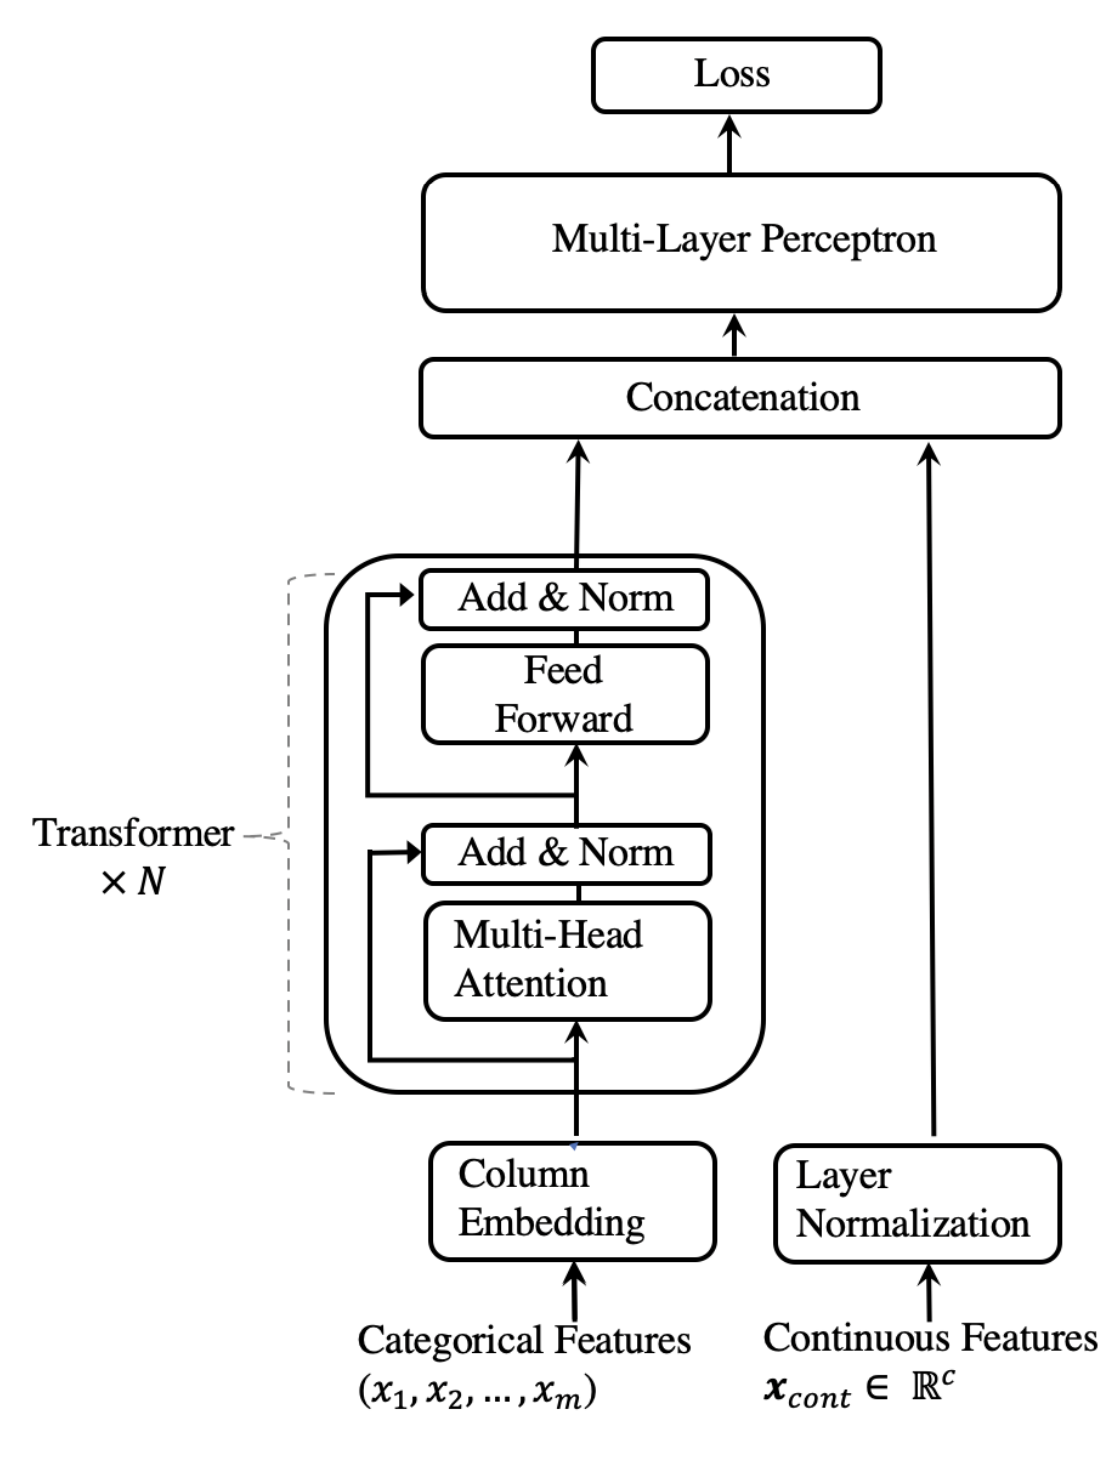

# Dependencies

In [1]:
import polars as pl
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score 
import keras
from keras import layers
from keras import ops

import os
import gc
import shutil
import joblib
import glob
from pathlib import Path

import math
import numpy as np
import pandas as pd
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, RegressorMixin
import warnings

2024-03-17 07:25:46.249378: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-17 07:25:46.249512: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-17 07:25:46.374273: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
class CFG:
    load_model=False
    n_splits=5
    load_folder=Path("/kaggle/input/home-credit-tabtransformer-keras-ds")
    debug=False
    debug_subsample=0.01
    class_weight={0: 1, 1: 1}

# Data Collection

In [3]:
import home_credit_baseline_data as data_nb

## Base Data

In [4]:
if not CFG.load_model:
    train_df = pd.read_parquet('/kaggle/usr/lib/home_credit_baseline_data/train_base.parquet')
    base_cat_cols = list(train_df.select_dtypes("object").columns)
    train_df[base_cat_cols] = train_df[base_cat_cols].astype("category")
    base_cat_cols = list(train_df.select_dtypes("category").columns)
    train_base_cols = train_df.columns
    display(train_df)

,case_id,WEEK_NUM,target,month_decision,weekday_decision,assignmentdate_238D,assignmentdate_4527235D,birthdate_574D,contractssum_5085716L,dateofbirth_337D,days120_123L,days180_256L,days30_165L,days360_512L,days90_310L,description_5085714M,education_1103M,education_88M,firstquarter_103L,fourthquarter_440L,maritalst_385M,maritalst_893M,numberofqueries_373L,pmtaverage_3A,pmtaverage_4527227A,pmtcount_4527229L,pmtcount_693L,pmtscount_423L,pmtssum_45A,requesttype_4525192L,responsedate_1012D,responsedate_4527233D,responsedate_4917613D,secondquarter_766L,thirdquarter_1082L,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,applicationscnt_629L,applicationscnt_867L,avgdbddpdlast24m_3658932P,avgdbddpdlast3m_4187120P,avgdbdtollast24m_4525197P,avgdpdtolclosure24_3658938P,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgmaxdpdlast9m_3716943P,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,bankacctype_710L,cardtype_51L,clientscnt12m_3712952L,clientscnt3m_3712950L,clientscnt6m_3712949L,clientscnt_100L,clientscnt_1022L,clientscnt_1071L,clientscnt_1130L,clientscnt_157L,clientscnt_257L,clientscnt_304L,clientscnt_360L,clientscnt_493L,clientscnt_533L,clientscnt_887L,clientscnt_946L,cntincpaycont9m_3716944L,cntpmts24_3658933L,commnoinclast6m_3546845L,credamount_770A,credtype_322L,currdebt_22A,currdebtcredtyperange_828A,datefirstoffer_1144D,datelastinstal40dpd_247D,datelastunpaid_3546854D,daysoverduetolerancedd_3976961L,deferredmnthsnum_166L,disbursedcredamount_1113A,disbursementtype_67L,downpmt_116A,dtlastpmtallstes_4499206D,eir_270L,equalitydataagreement_891L,firstclxcampaign_1125D,firstdatedue_489D,homephncnt_628L,inittransactionamount_650A,inittransactioncode_186L,interestrate_311L,isbidproduct_1095L,isdebitcard_729L,lastactivateddate_801D,lastapplicationdate_877D,lastapprcommoditycat_1041M,lastapprcredamount_781A,lastapprdate_640D,lastcancelreason_561M,lastdelinqdate_224D,lastrejectcommoditycat_161M,lastrejectcommodtypec_5251769M,lastrejectcredamount_222A,lastrejectdate_50D,lastrejectreason_759M,lastrejectreasonclient_4145040M,lastst_736L,maininc_215A,mastercontrelectronic_519L,mastercontrexist_109L,maxannuity_159A,maxdbddpdlast1m_3658939P,maxdbddpdtollast12m_3658940P,maxdbddpdtollast6m_4187119P,maxdebt4_972A,maxdpdfrom6mto36m_3546853P,maxdpdinstldate_3546855D,maxdpdinstlnum_3546846P,maxdpdlast12m_727P,maxdpdlast24m_143P,maxdpdlast3m_392P,maxdpdlast6m_474P,maxdpdlast9m_1059P,maxdpdtolerance_374P,maxinstallast24m_3658928A,maxlnamtstart6m_4525199A,maxoutstandbalancel12m_4187113A,maxpmtlast3m_4525190A,mindbddpdlast24m_3658935P,mindbdtollast24m_4525191P,mobilephncnt_593L,monthsannuity_845L,numactivecreds_622L,numactivecredschannel_414L,numactiverelcontr_750L,numcontrs3months_479L,numincomingpmts_3546848L,numinstlallpaidearly3d_817L,numinstls_657L,numinstlsallpaid_934L,numinstlswithdpd10_728L,numinstlswithdpd5_4187116L,numinstlswithoutdpd_562L,numinstmatpaidtearly2d_4499204L,numinstpaid_4499208L,numinstpaidearly3d_3546850L,numinstpaidearly3dest_4493216L,numinstpaidearly5d_1087L,numinstpaidearly5dest_4493211L,numinstpaidearly5dobd_4499205L,numinstpaidearly_338L,numinstpaidearlyest_4493214L,numinstpaidlastcontr_4325080L,numinstpaidlate1d_3546852L,numinstregularpaid_973L,numinstregularpaidest_4493210L,numinsttopaygr_769L,numinsttopaygrest_4493213L,numinstunpaidmax_3546851L,numinstunpaidmaxest_4493212L,numnotactivated_1143L,numpmtchanneldd_318L,numrejects9m_859L,opencred_647L,paytype1st_925L,paytype_783L,pctinstlsallpaidearl3d_427L,pctinstlsallpaidlat10d_839L,pctinstlsallpaidlate1d_3546856L,pctinstlsallpaidlate4d_3546849L,pctinstlsallpaidlate6d_3546844L,pmtnum_254L,posfpd10lastmonth_333P,posfpd30lastmonth_3976960P,posfstqpd30lastmonth_3976962P,price_1097A,sellerplacecnt_915L,sellerplacescnt_216L,sumoutstandtotal_3546847A,sumoutstandtotalest_4493215A,totaldebt_9A,totalsettled_863A,totinstallast1m_4525188A,twobodfilling_60

In [5]:
if not CFG.load_model:
    display(base_cat_cols)

['description_5085714M',
 'education_1103M',
 'education_88M',
 'maritalst_385M',
 'maritalst_893M',
 'requesttype_4525192L',
 'bankacctype_710L',
 'cardtype_51L',
 'credtype_322L',
 'disbursementtype_67L',
 'equalitydataagreement_891L',
 'inittransactioncode_186L',
 'isdebitcard_729L',
 'lastapprcommoditycat_1041M',
 'lastcancelreason_561M',
 'lastrejectcommoditycat_161M',
 'lastrejectcommodtypec_5251769M',
 'lastrejectreason_759M',
 'lastrejectreasonclient_4145040M',
 'lastst_736L',
 'opencred_647L',
 'paytype1st_925L',
 'paytype_783L',
 'twobodfilling_608L',
 'typesuite_864L',
 'max_cancelreason_3545846M',
 'max_education_1138M',
 'max_postype_4733339M',
 'max_rejectreason_755M',
 'max_rejectreasonclient_4145042M',
 'min_cancelreason_3545846M',
 'min_education_1138M',
 'min_postype_4733339M',
 'min_rejectreason_755M',
 'min_rejectreasonclient_4145042M',
 'first_cancelreason_3545846M',
 'first_education_1138M',
 'first_postype_4733339M',
 'first_rejectreason_755M',
 'first_rejectreas

# Preprocessing

### Drop columns

In [6]:
if not CFG.load_model:
    drop_cols = []
    drop_cols_startwith = ["mean_", "first_"]
    for name_prefix in drop_cols_startwith:
        cols_names = train_df.columns[train_df.columns.str.startswith(name_prefix)]
        drop_cols += cols_names.to_list()
    display(drop_cols)
    display(len(drop_cols))
else:
    train_base_cols, cat_cols, drop_cols = joblib.load(CFG.load_folder / "train_cat_columns.pkl")

['mean_actualdpd_943P',
 'mean_annuity_853A',
 'mean_credacc_actualbalance_314A',
 'mean_credacc_credlmt_575A',
 'mean_credacc_maxhisbal_375A',
 'mean_credacc_minhisbal_90A',
 'mean_credamount_590A',
 'mean_currdebt_94A',
 'mean_downpmt_134A',
 'mean_mainoccupationinc_437A',
 'mean_maxdpdtolerance_577P',
 'mean_outstandingdebt_522A',
 'mean_revolvingaccount_394A',
 'mean_approvaldate_319D',
 'mean_creationdate_885D',
 'mean_dateactivated_425D',
 'mean_dtlastpmt_581D',
 'mean_dtlastpmtallstes_3545839D',
 'mean_employedfrom_700D',
 'mean_firstnonzeroinstldate_307D',
 'mean_amount_4527230A',
 'mean_recorddate_4527225D',
 'mean_amount_4917619A',
 'mean_deductiondate_4917603D',
 'mean_pmtamount_36A',
 'mean_processingdate_168D',
 'mean_mainoccupationinc_384A',
 'mean_birth_259D',
 'mean_empl_employedfrom_271D',
 'mean_amount_416A',
 'mean_openingdate_313D',
 'mean_openingdate_857D',
 'first_actualdpd_943P',
 'first_annuity_853A',
 'first_credacc_credlmt_575A',
 'first_credamount_590A',
 'fi

99

In [7]:
if CFG.debug:
    train_df = train_df[: int(CFG.debug_subsample * train_df.shape[0])]
    print(train_df.shape)

In [8]:
if not CFG.load_model:
    train_df = train_df.sample(frac=1)

In [9]:
if not CFG.load_model:
    X = train_df.drop(columns=["target", "case_id", "WEEK_NUM"] + drop_cols)
    print("X shape: ", X.shape)
    y = train_df["target"]
    weeks = train_df["WEEK_NUM"]
    oof_df = train_df[["WEEK_NUM", "target"]].copy()

X shape:  (1526659, 415)


In [10]:
if not CFG.load_model:
    del train_df
    gc.collect()

In [11]:
if not CFG.load_model:
    cat_cols = X.select_dtypes("category").columns.to_list()
    num_cols = X.select_dtypes(exclude=['category']).columns.to_list()
    print("cat_cols len:\t\t\t", len(cat_cols))
    print("num_cols len:\t\t\t",  len(num_cols))
    print("X.columns len:\t\t\t",  len(X.columns))
    print("len(cat_cols)+len(num_cols):\t", len(cat_cols)+len(num_cols))

cat_cols len:			 114
num_cols len:			 301
X.columns len:			 415
len(cat_cols)+len(num_cols):	 415


## Imputing missing values

Impute missing numerical values with "0" using SimpleImputer.

In [12]:
if not CFG.load_model:
    imputer = SimpleImputer(missing_values=np.nan, strategy='constant', copy=False)
    imputer.fit(X[num_cols], y)

In [13]:
if not CFG.load_model:
    X_num_imputed = imputer.transform(X[num_cols])
    display(X_num_imputed)
    display(X_num_imputed.shape)

array([[12.,  2.,  0., ...,  0.,  0.,  0.],
       [ 6.,  2.,  0., ...,  0.,  0.,  0.],
       [11.,  3.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 8.,  6.,  0., ...,  0.,  0.,  0.],
       [12.,  2.,  0., ...,  0.,  0.,  0.],
       [ 2.,  5.,  0., ...,  0.,  0.,  0.]])

(1526659, 301)

In [14]:
if not CFG.load_model:
    X[num_cols] = X_num_imputed
    display(X)

,month_decision,weekday_decision,assignmentdate_238D,assignmentdate_4527235D,birthdate_574D,contractssum_5085716L,dateofbirth_337D,days120_123L,days180_256L,days30_165L,days360_512L,days90_310L,description_5085714M,education_1103M,education_88M,firstquarter_103L,fourthquarter_440L,maritalst_385M,maritalst_893M,numberofqueries_373L,pmtaverage_3A,pmtaverage_4527227A,pmtcount_4527229L,pmtcount_693L,pmtscount_423L,pmtssum_45A,requesttype_4525192L,responsedate_1012D,responsedate_4527233D,responsedate_4917613D,secondquarter_766L,thirdquarter_1082L,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,applicationscnt_629L,applicationscnt_867L,avgdbddpdlast24m_3658932P,avgdbddpdlast3m_4187120P,avgdbdtollast24m_4525197P,avgdpdtolclosure24_3658938P,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgmaxdpdlast9m_3716943P,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,bankacctype_710L,cardtype_51L,clientscnt12m_3712952L,clientscnt3m_3712950L,clientscnt6m_3712949L,clientscnt_100L,clientscnt_1022L,clientscnt_1071L,clientscnt_1130L,clientscnt_157L,clientscnt_257L,clientscnt_304L,clientscnt_360L,clientscnt_493L,clientscnt_533L,clientscnt_887L,clientscnt_946L,cntincpaycont9m_3716944L,cntpmts24_3658933L,commnoinclast6m_3546845L,credamount_770A,credtype_322L,currdebt_22A,currdebtcredtyperange_828A,datefirstoffer_1144D,datelastinstal40dpd_247D,datelastunpaid_3546854D,daysoverduetolerancedd_3976961L,deferredmnthsnum_166L,disbursedcredamount_1113A,disbursementtype_67L,downpmt_116A,dtlastpmtallstes_4499206D,eir_270L,equalitydataagreement_891L,firstclxcampaign_1125D,firstdatedue_489D,homephncnt_628L,inittransactionamount_650A,inittransactioncode_186L,interestrate_311L,isbidproduct_1095L,isdebitcard_729L,lastactivateddate_801D,lastapplicationdate_877D,lastapprcommoditycat_1041M,lastapprcredamount_781A,lastapprdate_640D,lastcancelreason_561M,lastdelinqdate_224D,lastrejectcommoditycat_161M,lastrejectcommodtypec_5251769M,lastrejectcredamount_222A,lastrejectdate_50D,lastrejectreason_759M,lastrejectreasonclient_4145040M,lastst_736L,maininc_215A,mastercontrelectronic_519L,mastercontrexist_109L,maxannuity_159A,maxdbddpdlast1m_3658939P,maxdbddpdtollast12m_3658940P,maxdbddpdtollast6m_4187119P,maxdebt4_972A,maxdpdfrom6mto36m_3546853P,maxdpdinstldate_3546855D,maxdpdinstlnum_3546846P,maxdpdlast12m_727P,maxdpdlast24m_143P,maxdpdlast3m_392P,maxdpdlast6m_474P,maxdpdlast9m_1059P,maxdpdtolerance_374P,maxinstallast24m_3658928A,maxlnamtstart6m_4525199A,maxoutstandbalancel12m_4187113A,maxpmtlast3m_4525190A,mindbddpdlast24m_3658935P,mindbdtollast24m_4525191P,mobilephncnt_593L,monthsannuity_845L,numactivecreds_622L,numactivecredschannel_414L,numactiverelcontr_750L,numcontrs3months_479L,numincomingpmts_3546848L,numinstlallpaidearly3d_817L,numinstls_657L,numinstlsallpaid_934L,numinstlswithdpd10_728L,numinstlswithdpd5_4187116L,numinstlswithoutdpd_562L,numinstmatpaidtearly2d_4499204L,numinstpaid_4499208L,numinstpaidearly3d_3546850L,numinstpaidearly3dest_4493216L,numinstpaidearly5d_1087L,numinstpaidearly5dest_4493211L,numinstpaidearly5dobd_4499205L,numinstpaidearly_338L,numinstpaidearlyest_4493214L,numinstpaidlastcontr_4325080L,numinstpaidlate1d_3546852L,numinstregularpaid_973L,numinstregularpaidest_4493210L,numinsttopaygr_769L,numinsttopaygrest_4493213L,numinstunpaidmax_3546851L,numinstunpaidmaxest_4493212L,numnotactivated_1143L,numpmtchanneldd_318L,numrejects9m_859L,opencred_647L,paytype1st_925L,paytype_783L,pctinstlsallpaidearl3d_427L,pctinstlsallpaidlat10d_839L,pctinstlsallpaidlate1d_3546856L,pctinstlsallpaidlate4d_3546849L,pctinstlsallpaidlate6d_3546844L,pmtnum_254L,posfpd10lastmonth_333P,posfpd30lastmonth_3976960P,posfstqpd30lastmonth_3976962P,price_1097A,sellerplacecnt_915L,sellerplacescnt_216L,sumoutstandtotal_3546847A,sumoutstandtotalest_4493215A,totaldebt_9A,totalsettled_863A,totinstallast1m_4525188A,twobodfilling_608L,typesuite_864L,validf

In [15]:
if not CFG.load_model:
    print(X[num_cols].isna().sum().sum())

0


In [16]:
if not CFG.load_model:
    del X_num_imputed
    gc.collect()

In [17]:
if not CFG.load_model:
    X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1526659 entries, 525746 to 695714
Columns: 415 entries, month_decision to last_num_group1_1_9
dtypes: category(114), float64(301)
memory usage: 3.6 GB


In [18]:
if not CFG.load_model:
    X = data_nb.reduce_mem_usage(X, float16_as32=False)

Memory usage of dataframe is 3687.94 MB
Memory usage after optimization is: 1291.47 MB
Decreased by 65.0%


In [19]:
if not CFG.load_model:
    X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1526659 entries, 525746 to 695714
Columns: 415 entries, month_decision to last_num_group1_1_9
dtypes: category(114), float16(221), float32(80)
memory usage: 1.3 GB


## Encoding categorical features

Here we encode the categorical columns using the modified LabelEncoder that handles unseen input values.

In [20]:
from sklearn.preprocessing import LabelEncoder
import bisect
import logging

class LabelEncoderRobust(LabelEncoder):
    def __init__(self):
        self.class_type = None

    def fit(self, y):
        super().fit(y)
        le_classes = self.classes_.tolist()
        logging.debug("LER classes: {}".format(le_classes))
        if len(le_classes) > 0:
            self.class_type = type(le_classes[0])

        logging.debug("LER classes type: {}".format(self.class_type))

        if self.class_type == str:
            bisect.insort_left(le_classes, 'UNKNOWN_LBL')
        if self.class_type == int:
            bisect.insort_left(le_classes, -999)

        self.classes_ = np.array(le_classes)

    def transform(self, y):
        for i in range(len(y)):
            item = y[i]
            if item not in self.classes_:
                logging.debug("transform LER classes type: {}".format(self.class_type))
                if self.class_type == str:
                    y[i] = 'UNKNOWN_LBL'
                elif self.class_type == int:
                    y[i] = -999
                else:
                    raise ValueError("list_type in None, cannot transform")

        return super().transform(y)

In [21]:
%%time
if not CFG.load_model:
    if os.path.isfile(CFG.load_folder / "le_all_cols.pkl"):
        le_all_cols = joblib.load(CFG.load_folder / "le_all_cols.pkl")
    else:
        le_all_cols = {}
        print("fit encoders:")
        for i, col in enumerate(cat_cols):
            print(i, col)
            le = LabelEncoderRobust()
            le.fit(X[col].astype(str))
            le_all_cols[col] = le
    print("transform cols:")
    for i, col in enumerate(cat_cols):
        print(i, col)
        le = le_all_cols[col]
        X[col] = le.transform(X[col].astype(str))        

fit encoders:
0 description_5085714M
1 education_1103M
2 education_88M
3 maritalst_385M
4 maritalst_893M
5 requesttype_4525192L
6 bankacctype_710L
7 cardtype_51L
8 credtype_322L
9 disbursementtype_67L
10 equalitydataagreement_891L
11 inittransactioncode_186L
12 isdebitcard_729L
13 lastapprcommoditycat_1041M
14 lastcancelreason_561M
15 lastrejectcommoditycat_161M
16 lastrejectcommodtypec_5251769M
17 lastrejectreason_759M
18 lastrejectreasonclient_4145040M
19 lastst_736L
20 opencred_647L
21 paytype1st_925L
22 paytype_783L
23 twobodfilling_608L
24 typesuite_864L
25 max_cancelreason_3545846M
26 max_education_1138M
27 max_postype_4733339M
28 max_rejectreason_755M
29 max_rejectreasonclient_4145042M
30 min_cancelreason_3545846M
31 min_education_1138M
32 min_postype_4733339M
33 min_rejectreason_755M
34 min_rejectreasonclient_4145042M
35 last_cancelreason_3545846M
36 last_education_1138M
37 last_postype_4733339M
38 last_rejectreason_755M
39 last_rejectreasonclient_4145042M
40 mode_cancelreason_

# Model

## Configuration

In [22]:
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
DROPOUT_RATE = 0.2
BATCH_SIZE = 128
NUM_EPOCHS = 2

NUM_TRANSFORMER_BLOCKS = 3  # Number of transformer blocks.
NUM_HEADS = 4  # Number of attention heads.
EMBEDDING_DIMS = 8  # Embedding dimensions of the categorical features.
MLP_HIDDEN_UNITS_FACTORS = [
    2,
    1,
]  # MLP hidden layer units, as factors of the number of inputs.

In [23]:
if not CFG.load_model:
    CATEGORICAL_FEATURES_WITH_VOCABULARY= {}
    for col in cat_cols:
        CATEGORICAL_FEATURES_WITH_VOCABULARY[col] = sorted(list(X[col].unique()))
    joblib.dump(CATEGORICAL_FEATURES_WITH_VOCABULARY, "CATEGORICAL_FEATURES_WITH_VOCABULARY.pkl")
else:
    CATEGORICAL_FEATURES_WITH_VOCABULARY = joblib.load(CFG.load_folder / "CATEGORICAL_FEATURES_WITH_VOCABULARY.pkl")

## Encode inputs

In [24]:
if not CFG.load_model:
    featcols = list(num_cols) + list(cat_cols)

def create_model_inputs():
    inputs = {}
    for feature_name in featcols:
        if feature_name in num_cols:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype="float32"
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype="float32"
            )
    return inputs

In [25]:
from functools import partial

def encode_inputs(inputs, embedding_dims):
    encoded_categorical_feature_list = []
    numerical_feature_list = []

    for feature_name in inputs:
        if feature_name in cat_cols:
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
            embedding = layers.Embedding(
                input_dim=len(vocabulary), output_dim=embedding_dims
            )

            # Convert the index values to embedding representations.
            encoded_categorical_feature = embedding(inputs[feature_name])
            encoded_categorical_feature_list.append(encoded_categorical_feature)

        else:
            # Use the numerical features as-is.
            numerical_feature = ops.expand_dims(inputs[feature_name], -1)
            numerical_feature_list.append(numerical_feature)

    return encoded_categorical_feature_list, numerical_feature_list

## Model Building

In [26]:
def create_mlp(hidden_units, dropout_rate, activation, normalization_layer, name=None):
    mlp_layers = []
    for units in hidden_units:
        mlp_layers.append(normalization_layer()),
        mlp_layers.append(layers.Dense(units, activation=activation))
        mlp_layers.append(layers.Dropout(dropout_rate))

    return keras.Sequential(mlp_layers, name=name)

def create_tabtransformer_classifier(
    num_transformer_blocks,
    num_heads,
    embedding_dims,
    mlp_hidden_units_factors,
    dropout_rate,
    use_column_embedding=False,
):
    # Create model inputs.
    inputs = create_model_inputs()
    # encode features.
    encoded_categorical_feature_list, numerical_feature_list = encode_inputs(
        inputs, embedding_dims
    )
    # Stack categorical feature embeddings for the Tansformer.
    encoded_categorical_features = ops.stack(encoded_categorical_feature_list, axis=1)
    # Concatenate numerical features.
    numerical_features = layers.concatenate(numerical_feature_list)

    # Add column embedding to categorical feature embeddings.
    if use_column_embedding:
        num_columns = encoded_categorical_features.shape[1]
        column_embedding = layers.Embedding(
            input_dim=num_columns, output_dim=embedding_dims
        )
        column_indices = ops.arange(start=0, stop=num_columns, step=1)
        encoded_categorical_features = encoded_categorical_features + column_embedding(
            column_indices
        )

    # Create multiple layers of the Transformer block.
    for block_idx in range(num_transformer_blocks):
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dims,
            dropout=dropout_rate,
            name=f"multihead_attention_{block_idx}",
        )(encoded_categorical_features, encoded_categorical_features)
        # Skip connection 1.
        x = layers.Add(name=f"skip_connection1_{block_idx}")(
            [attention_output, encoded_categorical_features]
        )
        # Layer normalization 1.
        x = layers.LayerNormalization(
            name=f"layer_norm1_{block_idx}", 
            epsilon=1e-6
        )(x)
        # Feedforward.
        feedforward_output = create_mlp(
            hidden_units=[embedding_dims],
            dropout_rate=dropout_rate,
            activation=keras.activations.gelu,
            normalization_layer=partial(
                layers.LayerNormalization, 
                epsilon=1e-6
            ),  # using partial to provide keyword arguments before initialization
            name=f"feedforward_{block_idx}",
        )(x)
        # Skip connection 2.
        x = layers.Add(name=f"skip_connection2_{block_idx}")([feedforward_output, x])
        # Layer normalization 2.
        encoded_categorical_features = layers.LayerNormalization(
            name=f"layer_norm2_{block_idx}", 
            epsilon=1e-6
        )(x)

    # Flatten the "contextualized" embeddings of the categorical features.
    categorical_features = layers.Flatten()(encoded_categorical_features)
    # Apply layer normalization to the numerical features.
    numerical_features = layers.LayerNormalization(
        epsilon=1e-6
    )(numerical_features)
    # Prepare the input for the final MLP block.
    features = layers.concatenate([categorical_features, numerical_features])

    # Compute MLP hidden_units.
    mlp_hidden_units = [
        factor * features.shape[-1] for factor in mlp_hidden_units_factors
    ]
    # Create final MLP.
    features = create_mlp(
        hidden_units=mlp_hidden_units,
        dropout_rate=dropout_rate,
        activation=keras.activations.selu,
        normalization_layer=layers.BatchNormalization,
        name="MLP",
    )(features)

    # Add a sigmoid as a binary classifer.
    outputs = layers.Dense(units=1, activation="sigmoid", name="sigmoid")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [27]:
def create_tab_transformer():
    tabtransformer_model = create_tabtransformer_classifier(
        num_transformer_blocks=NUM_TRANSFORMER_BLOCKS,
        num_heads=NUM_HEADS,
        embedding_dims=EMBEDDING_DIMS,
        mlp_hidden_units_factors=MLP_HIDDEN_UNITS_FACTORS,
        dropout_rate=DROPOUT_RATE,
    )
    optimizer = keras.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )
    tabtransformer_model.compile(
        optimizer=optimizer,
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[
            keras.metrics.AUC(name="auc"),
            keras.metrics.BinaryAccuracy(name="accuracy")
        ],
    )
    return tabtransformer_model

In [28]:
class TabTransformersVotingModel(BaseEstimator, RegressorMixin):
    def __init__(self, estimators=[], batch_size=512):
        super().__init__()
        self.estimators = estimators
        self.batch_size = batch_size
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        y_preds = [estimator.predict([X[col] for col in X.columns], batch_size=self.batch_size) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)
    
    def save(self, folder):
        if not os.path.exists(folder):
            os.makedirs(folder)
        for i, estimator in enumerate(self.estimators):
            estimator.save(f"{folder}/estimator_{i}.keras")
            
    def load_model(self, folder):
        for file in glob.glob(f"{folder}/*"):
            estimator = keras.models.load_model(file)
            self.estimators.append(estimator)
        return self

# Training and Evaluation

In [29]:
def gini_stability(base, score_col="score", w_fallingrate=88.0, w_resstd=-0.5):
    gini_in_time = base.loc[:, ["WEEK_NUM", "target", score_col]]\
        .sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")[["target", score_col]]\
        .apply(lambda x: 2*roc_auc_score(x["target"], x[score_col])-1).tolist()
    
    x = np.arange(len(gini_in_time))
    y = gini_in_time
    a, b = np.polyfit(x, y, 1)
    y_hat = a*x + b
    residuals = y - y_hat
    res_std = np.std(residuals)
    avg_gini = np.mean(gini_in_time)
    return avg_gini + w_fallingrate * min(0, a) + w_resstd * res_std

In [30]:
from sklearn.utils import class_weight
if not CFG.load_model:
    class_weights = class_weight.compute_class_weight(
        class_weight="balanced", 
        classes=np.unique(y), 
        y=y
    )
    print("computed class_weights: ", class_weights)

computed class_weights:  [ 0.51622883 15.904686  ]


In [31]:
if not CFG.load_model:
    cv = StratifiedGroupKFold(n_splits=CFG.n_splits, shuffle=False)
    
    fitted_models = []
    oof_pred = np.zeros(X.shape[0])

    for i, (idx_train, idx_valid) in enumerate(cv.split(X, y, groups=weeks)):
        print("Fold: ", i)
        X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

        model = create_tab_transformer()
        history = model.fit(
            [X_train[col] for col in X_train.columns],
            y_train, 
            epochs=NUM_EPOCHS,
            batch_size=BATCH_SIZE,
            validation_data=(
                [X_valid[col] for col in X_valid.columns],
                y_valid
            ),
            validation_batch_size=512,
            class_weight=CFG.class_weight,
        )
        
        fitted_models.append(model)
        val_pred = model.predict([X_valid[col] for col in X_valid.columns], batch_size=512)
        oof_pred[idx_valid] = val_pred.flatten()
        
        del X_train, X_valid
        gc.collect()
        
    oof_models_dict = [(str(i), model) for i, model in enumerate(fitted_models)]
    model = TabTransformersVotingModel(fitted_models)

Fold:  0
Epoch 1/2
   2/9540 ━━━━━━━━━━━━━━━━━━━━ 8:05 51ms/step - accuracy: 0.4336 - auc: 0.4934 - loss: 4.1758    

I0000 00:00:1710662652.523566      88 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


9540/9540 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9634 - auc: 0.6548 - loss: 0.1864

W0000 00:00:1710663021.526427      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710663031.824639      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


9540/9540 ━━━━━━━━━━━━━━━━━━━━ 459s 42ms/step - accuracy: 0.9634 - auc: 0.6548 - loss: 0.1864 - val_accuracy: 0.9665 - val_auc: 0.7279 - val_loss: 0.1522
Epoch 2/2


W0000 00:00:1710663049.029673      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


9540/9540 ━━━━━━━━━━━━━━━━━━━━ 359s 38ms/step - accuracy: 0.9688 - auc: 0.7155 - loss: 0.1313 - val_accuracy: 0.9665 - val_auc: 0.7735 - val_loss: 0.1315
  5/597 ━━━━━━━━━━━━━━━━━━━━ 24s 41ms/step

W0000 00:00:1710663418.809270      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


597/597 ━━━━━━━━━━━━━━━━━━━━ 40s 54ms/step


W0000 00:00:1710663451.003948      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Fold:  1
Epoch 1/2
9541/9541 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9627 - auc: 0.6595 - loss: 0.1820

W0000 00:00:1710663925.567444      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


9541/9541 ━━━━━━━━━━━━━━━━━━━━ 483s 44ms/step - accuracy: 0.9627 - auc: 0.6595 - loss: 0.1820 - val_accuracy: 0.9697 - val_auc: 0.7603 - val_loss: 0.1273
Epoch 2/2


W0000 00:00:1710663943.874575      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


9541/9541 ━━━━━━━━━━━━━━━━━━━━ 377s 39ms/step - accuracy: 0.9679 - auc: 0.7185 - loss: 0.1337 - val_accuracy: 0.9697 - val_auc: 0.7647 - val_loss: 0.1221
  5/597 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step

W0000 00:00:1710664330.353638      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


597/597 ━━━━━━━━━━━━━━━━━━━━ 41s 56ms/step


W0000 00:00:1710664363.676249      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Fold:  2
Epoch 1/2
9541/9541 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9636 - auc: 0.6460 - loss: 0.1864

W0000 00:00:1710664853.664323      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


9541/9541 ━━━━━━━━━━━━━━━━━━━━ 497s 46ms/step - accuracy: 0.9636 - auc: 0.6460 - loss: 0.1863 - val_accuracy: 0.9691 - val_auc: 0.7579 - val_loss: 0.1298
Epoch 2/2


W0000 00:00:1710664871.690467      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


9541/9541 ━━━━━━━━━━━━━━━━━━━━ 382s 40ms/step - accuracy: 0.9682 - auc: 0.7155 - loss: 0.1333 - val_accuracy: 0.9691 - val_auc: 0.7710 - val_loss: 0.1258
  5/597 ━━━━━━━━━━━━━━━━━━━━ 24s 41ms/step

W0000 00:00:1710665262.955284      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


597/597 ━━━━━━━━━━━━━━━━━━━━ 40s 54ms/step


W0000 00:00:1710665295.117799      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Fold:  3
Epoch 1/2
9543/9543 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9631 - auc: 0.6540 - loss: 0.1832

W0000 00:00:1710665774.191930      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


9543/9543 ━━━━━━━━━━━━━━━━━━━━ 486s 45ms/step - accuracy: 0.9631 - auc: 0.6540 - loss: 0.1832 - val_accuracy: 0.9684 - val_auc: 0.7269 - val_loss: 0.1591
Epoch 2/2


W0000 00:00:1710665792.363608      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


9543/9543 ━━━━━━━━━━━━━━━━━━━━ 383s 40ms/step - accuracy: 0.9686 - auc: 0.7103 - loss: 0.1329 - val_accuracy: 0.9684 - val_auc: 0.7716 - val_loss: 0.1387
  5/597 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step

W0000 00:00:1710666185.814349      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


597/597 ━━━━━━━━━━━━━━━━━━━━ 40s 55ms/step


W0000 00:00:1710666218.791353      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Fold:  4
Epoch 1/2
9545/9545 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9627 - auc: 0.6583 - loss: 0.1911

W0000 00:00:1710666704.014196      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


9545/9545 ━━━━━━━━━━━━━━━━━━━━ 492s 45ms/step - accuracy: 0.9627 - auc: 0.6583 - loss: 0.1911 - val_accuracy: 0.9690 - val_auc: 0.7600 - val_loss: 0.1252
Epoch 2/2


W0000 00:00:1710666721.818077      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


9545/9545 ━━━━━━━━━━━━━━━━━━━━ 392s 41ms/step - accuracy: 0.9682 - auc: 0.7177 - loss: 0.1327 - val_accuracy: 0.9690 - val_auc: 0.7449 - val_loss: 0.1469
  5/596 ━━━━━━━━━━━━━━━━━━━━ 24s 42ms/step

W0000 00:00:1710667123.807595      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


596/596 ━━━━━━━━━━━━━━━━━━━━ 42s 58ms/step


W0000 00:00:1710667158.292992      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [32]:
if CFG.load_model:
    from_directory = CFG.load_folder / "tabtransformer_voting_model"
    to_directory = "/kaggle/working/tabtransformer_voting_model"
    shutil.copytree(from_directory, to_directory)

In [33]:
if CFG.load_model:
    train_df = pd.read_parquet("/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/train/train_base.parquet")
    y = train_df["target"]
    oof_df = train_df[["WEEK_NUM", "target"]].copy()
    model = TabTransformersVotingModel().load_model("tabtransformer_voting_model")
    oof_pred = joblib.load(CFG.load_folder / "oof_pred.pkl")

In [34]:
roc_auc_oof = roc_auc_score(y, oof_pred)
print("CV roc_auc_oof: ", roc_auc_oof)

CV roc_auc_oof:  0.7106361684565721


In [35]:
if not CFG.debug:
    oof_df["pred_oof"] = oof_pred
    gini_score = gini_stability(oof_df, score_col="pred_oof")
    print("gini_score:\t", gini_score)

gini_score:	 0.5153192626324015


### Save model and data

In [36]:
if not CFG.load_model:
    model.save("tabtransformer_voting_model")

In [37]:
if not CFG.load_model:
    joblib.dump(oof_pred, "oof_pred.pkl")

In [38]:
if not CFG.load_model:
    joblib.dump(le_all_cols, "le_all_cols.pkl")
    joblib.dump(imputer, "imputer.pkl")

In [39]:
if not CFG.load_model:
    joblib.dump((train_base_cols, base_cat_cols, drop_cols), "train_cat_columns.pkl")

# Test Data Collection

In [40]:
if CFG.load_model:
    train_base_cols, base_cat_cols, drop_cols = joblib.load("train_cat_columns.pkl")

In [41]:
test_df = data_nb.prepare_df(
    data_nb.base_files,
    data_nb.CFG.test_dir,
    data_nb.base_agg,
    mode="test", 
    cat_cols=base_cat_cols, 
    train_cols=train_base_cols
)
display(test_df)


  files:  test_base.parquet
  chunk:  0
  files:  _static_cb_0.parquet (depth: 0)
  chunk:  0
  files:  _static_0_*.parquet (depth: 0)
  chunk:  0
  chunk:  1
  chunk:  2
  files:  _applprev_1_*.parquet (depth: 1)
  chunk:  0
  chunk:  1
  chunk:  2
  agg, depth 1
  files:  _tax_registry_a_1.parquet (depth: 1)
  chunk:  0
  agg, depth 1
  files:  _tax_registry_b_1.parquet (depth: 1)
  chunk:  0
  agg, depth 1
  files:  _tax_registry_c_1.parquet (depth: 1)
  chunk:  0
  agg, depth 1
  files:  _other_1.parquet (depth: 1)
  chunk:  0
  agg, depth 1
  files:  _person_1.parquet (depth: 1)
  chunk:  0
  agg, depth 1
  files:  _deposit_1.parquet (depth: 1)
  chunk:  0
  agg, depth 1
  files:  _debitcard_1.parquet (depth: 1)
  chunk:  0
  agg, depth 1
  files:  _credit_bureau_b_1.parquet (depth: 1)
  chunk:  0
  agg, depth 1
  files:  _credit_bureau_b_2.parquet (depth: 2)
  chunk:  0
  agg, depth 2
  feats_df shape:	 (10, 926)
Feature Engineering...
Filter cols...
  feats_df shape:	 (10, 516)

,case_id,WEEK_NUM,month_decision,weekday_decision,assignmentdate_238D,assignmentdate_4527235D,birthdate_574D,contractssum_5085716L,dateofbirth_337D,days120_123L,days180_256L,days30_165L,days360_512L,days90_310L,description_5085714M,education_1103M,education_88M,firstquarter_103L,fourthquarter_440L,maritalst_385M,maritalst_893M,numberofqueries_373L,pmtaverage_3A,pmtaverage_4527227A,pmtcount_4527229L,pmtcount_693L,pmtscount_423L,pmtssum_45A,requesttype_4525192L,responsedate_1012D,responsedate_4527233D,responsedate_4917613D,secondquarter_766L,thirdquarter_1082L,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,applicationscnt_629L,applicationscnt_867L,avgdbddpdlast24m_3658932P,avgdbddpdlast3m_4187120P,avgdbdtollast24m_4525197P,avgdpdtolclosure24_3658938P,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgmaxdpdlast9m_3716943P,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,bankacctype_710L,cardtype_51L,clientscnt12m_3712952L,clientscnt3m_3712950L,clientscnt6m_3712949L,clientscnt_100L,clientscnt_1022L,clientscnt_1071L,clientscnt_1130L,clientscnt_157L,clientscnt_257L,clientscnt_304L,clientscnt_360L,clientscnt_493L,clientscnt_533L,clientscnt_887L,clientscnt_946L,cntincpaycont9m_3716944L,cntpmts24_3658933L,commnoinclast6m_3546845L,credamount_770A,credtype_322L,currdebt_22A,currdebtcredtyperange_828A,datefirstoffer_1144D,datelastinstal40dpd_247D,datelastunpaid_3546854D,daysoverduetolerancedd_3976961L,deferredmnthsnum_166L,disbursedcredamount_1113A,disbursementtype_67L,downpmt_116A,dtlastpmtallstes_4499206D,eir_270L,equalitydataagreement_891L,firstclxcampaign_1125D,firstdatedue_489D,homephncnt_628L,inittransactionamount_650A,inittransactioncode_186L,interestrate_311L,isbidproduct_1095L,isdebitcard_729L,lastactivateddate_801D,lastapplicationdate_877D,lastapprcommoditycat_1041M,lastapprcredamount_781A,lastapprdate_640D,lastcancelreason_561M,lastdelinqdate_224D,lastrejectcommoditycat_161M,lastrejectcommodtypec_5251769M,lastrejectcredamount_222A,lastrejectdate_50D,lastrejectreason_759M,lastrejectreasonclient_4145040M,lastst_736L,maininc_215A,mastercontrelectronic_519L,mastercontrexist_109L,maxannuity_159A,maxdbddpdlast1m_3658939P,maxdbddpdtollast12m_3658940P,maxdbddpdtollast6m_4187119P,maxdebt4_972A,maxdpdfrom6mto36m_3546853P,maxdpdinstldate_3546855D,maxdpdinstlnum_3546846P,maxdpdlast12m_727P,maxdpdlast24m_143P,maxdpdlast3m_392P,maxdpdlast6m_474P,maxdpdlast9m_1059P,maxdpdtolerance_374P,maxinstallast24m_3658928A,maxlnamtstart6m_4525199A,maxoutstandbalancel12m_4187113A,maxpmtlast3m_4525190A,mindbddpdlast24m_3658935P,mindbdtollast24m_4525191P,mobilephncnt_593L,monthsannuity_845L,numactivecreds_622L,numactivecredschannel_414L,numactiverelcontr_750L,numcontrs3months_479L,numincomingpmts_3546848L,numinstlallpaidearly3d_817L,numinstls_657L,numinstlsallpaid_934L,numinstlswithdpd10_728L,numinstlswithdpd5_4187116L,numinstlswithoutdpd_562L,numinstmatpaidtearly2d_4499204L,numinstpaid_4499208L,numinstpaidearly3d_3546850L,numinstpaidearly3dest_4493216L,numinstpaidearly5d_1087L,numinstpaidearly5dest_4493211L,numinstpaidearly5dobd_4499205L,numinstpaidearly_338L,numinstpaidearlyest_4493214L,numinstpaidlastcontr_4325080L,numinstpaidlate1d_3546852L,numinstregularpaid_973L,numinstregularpaidest_4493210L,numinsttopaygr_769L,numinsttopaygrest_4493213L,numinstunpaidmax_3546851L,numinstunpaidmaxest_4493212L,numnotactivated_1143L,numpmtchanneldd_318L,numrejects9m_859L,opencred_647L,paytype1st_925L,paytype_783L,pctinstlsallpaidearl3d_427L,pctinstlsallpaidlat10d_839L,pctinstlsallpaidlate1d_3546856L,pctinstlsallpaidlate4d_3546849L,pctinstlsallpaidlate6d_3546844L,pmtnum_254L,posfpd10lastmonth_333P,posfpd30lastmonth_3976960P,posfstqpd30lastmonth_3976962P,price_1097A,sellerplacecnt_915L,sellerplacescnt_216L,sumoutstandtotal_3546847A,sumoutstandtotalest_4493215A,totaldebt_9A,totalsettled_863A,totinstallast1m_4525188A,twobodfilling_608L,type

## Test Data Preprocessing

In [42]:
X_test = test_df.drop(columns=drop_cols + ["WEEK_NUM"])
X_test = X_test.set_index("case_id")
print("X_test shape: ", X_test.shape)

X_test shape:  (10, 415)


In [43]:
if CFG.load_model:
    le_all_cols = joblib.load(CFG.load_folder / "le_all_cols.pkl")
    imputer = joblib.load(CFG.load_folder / "imputer.pkl")

In [44]:
num_cols = X_test.columns[~np.in1d(X_test.columns, cat_cols)]
len(num_cols)

301

In [45]:
X_test_num_imputed = imputer.transform(X_test[num_cols])
X_test[num_cols] = X_test_num_imputed
display(X_test_num_imputed)
display(X_test_num_imputed.shape)

array([[ 5.,  5.,  0., ...,  0.,  0.,  0.],
       [ 1.,  1.,  0., ...,  0.,  0.,  0.],
       [11.,  5.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 2.,  6.,  0., ...,  0.,  0.,  0.],
       [ 1.,  2.,  0., ...,  0.,  0.,  0.],
       [ 1.,  3.,  0., ...,  0.,  0.,  0.]])

(10, 301)

In [46]:
for i, col in enumerate(cat_cols):
    print(i, col)
    le = le_all_cols[col]
    try:
        X_test[col] = le.transform(list(X_test[col].astype(str)))
    except Exception as error:
        X_test[col] = -999
        print("--- An exception occurred:", error)

0 description_5085714M
1 education_1103M
2 education_88M
3 maritalst_385M
4 maritalst_893M
5 requesttype_4525192L
6 bankacctype_710L
7 cardtype_51L
8 credtype_322L
9 disbursementtype_67L
10 equalitydataagreement_891L
11 inittransactioncode_186L
12 isdebitcard_729L
13 lastapprcommoditycat_1041M
14 lastcancelreason_561M
15 lastrejectcommoditycat_161M
16 lastrejectcommodtypec_5251769M
17 lastrejectreason_759M
18 lastrejectreasonclient_4145040M
19 lastst_736L
20 opencred_647L
21 paytype1st_925L
22 paytype_783L
23 twobodfilling_608L
24 typesuite_864L
25 max_cancelreason_3545846M
26 max_education_1138M
27 max_postype_4733339M
28 max_rejectreason_755M
29 max_rejectreasonclient_4145042M
30 min_cancelreason_3545846M
31 min_education_1138M
32 min_postype_4733339M
33 min_rejectreason_755M
34 min_rejectreasonclient_4145042M
35 last_cancelreason_3545846M
36 last_education_1138M
37 last_postype_4733339M
38 last_rejectreason_755M
39 last_rejectreasonclient_4145042M
40 mode_cancelreason_3545846M
41 mo

In [47]:
display(X_test)

,month_decision,weekday_decision,assignmentdate_238D,assignmentdate_4527235D,birthdate_574D,contractssum_5085716L,dateofbirth_337D,days120_123L,days180_256L,days30_165L,days360_512L,days90_310L,description_5085714M,education_1103M,education_88M,firstquarter_103L,fourthquarter_440L,maritalst_385M,maritalst_893M,numberofqueries_373L,pmtaverage_3A,pmtaverage_4527227A,pmtcount_4527229L,pmtcount_693L,pmtscount_423L,pmtssum_45A,requesttype_4525192L,responsedate_1012D,responsedate_4527233D,responsedate_4917613D,secondquarter_766L,thirdquarter_1082L,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,applicationscnt_629L,applicationscnt_867L,avgdbddpdlast24m_3658932P,avgdbddpdlast3m_4187120P,avgdbdtollast24m_4525197P,avgdpdtolclosure24_3658938P,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgmaxdpdlast9m_3716943P,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,bankacctype_710L,cardtype_51L,clientscnt12m_3712952L,clientscnt3m_3712950L,clientscnt6m_3712949L,clientscnt_100L,clientscnt_1022L,clientscnt_1071L,clientscnt_1130L,clientscnt_157L,clientscnt_257L,clientscnt_304L,clientscnt_360L,clientscnt_493L,clientscnt_533L,clientscnt_887L,clientscnt_946L,cntincpaycont9m_3716944L,cntpmts24_3658933L,commnoinclast6m_3546845L,credamount_770A,credtype_322L,currdebt_22A,currdebtcredtyperange_828A,datefirstoffer_1144D,datelastinstal40dpd_247D,datelastunpaid_3546854D,daysoverduetolerancedd_3976961L,deferredmnthsnum_166L,disbursedcredamount_1113A,disbursementtype_67L,downpmt_116A,dtlastpmtallstes_4499206D,eir_270L,equalitydataagreement_891L,firstclxcampaign_1125D,firstdatedue_489D,homephncnt_628L,inittransactionamount_650A,inittransactioncode_186L,interestrate_311L,isbidproduct_1095L,isdebitcard_729L,lastactivateddate_801D,lastapplicationdate_877D,lastapprcommoditycat_1041M,lastapprcredamount_781A,lastapprdate_640D,lastcancelreason_561M,lastdelinqdate_224D,lastrejectcommoditycat_161M,lastrejectcommodtypec_5251769M,lastrejectcredamount_222A,lastrejectdate_50D,lastrejectreason_759M,lastrejectreasonclient_4145040M,lastst_736L,maininc_215A,mastercontrelectronic_519L,mastercontrexist_109L,maxannuity_159A,maxdbddpdlast1m_3658939P,maxdbddpdtollast12m_3658940P,maxdbddpdtollast6m_4187119P,maxdebt4_972A,maxdpdfrom6mto36m_3546853P,maxdpdinstldate_3546855D,maxdpdinstlnum_3546846P,maxdpdlast12m_727P,maxdpdlast24m_143P,maxdpdlast3m_392P,maxdpdlast6m_474P,maxdpdlast9m_1059P,maxdpdtolerance_374P,maxinstallast24m_3658928A,maxlnamtstart6m_4525199A,maxoutstandbalancel12m_4187113A,maxpmtlast3m_4525190A,mindbddpdlast24m_3658935P,mindbdtollast24m_4525191P,mobilephncnt_593L,monthsannuity_845L,numactivecreds_622L,numactivecredschannel_414L,numactiverelcontr_750L,numcontrs3months_479L,numincomingpmts_3546848L,numinstlallpaidearly3d_817L,numinstls_657L,numinstlsallpaid_934L,numinstlswithdpd10_728L,numinstlswithdpd5_4187116L,numinstlswithoutdpd_562L,numinstmatpaidtearly2d_4499204L,numinstpaid_4499208L,numinstpaidearly3d_3546850L,numinstpaidearly3dest_4493216L,numinstpaidearly5d_1087L,numinstpaidearly5dest_4493211L,numinstpaidearly5dobd_4499205L,numinstpaidearly_338L,numinstpaidearlyest_4493214L,numinstpaidlastcontr_4325080L,numinstpaidlate1d_3546852L,numinstregularpaid_973L,numinstregularpaidest_4493210L,numinsttopaygr_769L,numinsttopaygrest_4493213L,numinstunpaidmax_3546851L,numinstunpaidmaxest_4493212L,numnotactivated_1143L,numpmtchanneldd_318L,numrejects9m_859L,opencred_647L,paytype1st_925L,paytype_783L,pctinstlsallpaidearl3d_427L,pctinstlsallpaidlat10d_839L,pctinstlsallpaidlate1d_3546856L,pctinstlsallpaidlate4d_3546849L,pctinstlsallpaidlate6d_3546844L,pmtnum_254L,posfpd10lastmonth_333P,posfpd30lastmonth_3976960P,posfstqpd30lastmonth_3976962P,price_1097A,sellerplacecnt_915L,sellerplacescnt_216L,sumoutstandtotal_3546847A,sumoutstandtotalest_4493215A,totaldebt_9A,totalsettled_863A,totinstallast1m_4525188A,twobodfilling_608L,typesuite_864L,validf

## Prediction

In [48]:
def predict_proba_in_batches(model, data, batch_size=80000):
    num_samples = len(data)
    num_batches = int(np.ceil(num_samples / batch_size))
    probabilities = np.zeros((num_samples,))

    for batch_idx in range(num_batches):
        print(f"Processing batch: {batch_idx+1}/{num_batches}")
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, num_samples)
        X_batch = data.iloc[start_idx:end_idx]
        batch_probs = model.predict(X_batch).flatten()
        probabilities[start_idx:end_idx] = batch_probs
        gc.collect()

    return probabilities

In [49]:
y_pred = pd.Series(predict_proba_in_batches(model, X_test), index=X_test.index)
y_pred[:10]

Processing batch: 1/1
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


case_id
57543    0.033276
57549    0.031682
57551    0.016854
57552    0.022003
57569    0.042127
57630    0.018532
57631    0.025058
57632    0.005620
57633    0.028340
57634    0.010651
dtype: float64

# Submission

In [50]:
subm_df = pd.read_csv(data_nb.CFG.root_dir / "sample_submission.csv")
subm_df = subm_df.set_index("case_id")

subm_df["score"] = y_pred

In [51]:
print("Check null: ", subm_df["score"].isnull().any())

subm_df.head()

Check null:  False


,score
case_id,
57543,0.033276
57549,0.031682
57551,0.016854
57552,0.022003
57569,0.042127


In [52]:
subm_df.to_csv("submission.csv")